In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, cross_validate, cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, homogeneity_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFECV, SequentialFeatureSelector
import xgboost as xgb 
from sklearn.pipeline import make_pipeline
import mlflow
from mlflow.tracking import MlflowClient
import pickle

# Uncomment to enable feature selection libraries, make sure to install first
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils import class_weight
import random 

In [2]:
seed = 2021
random.seed(seed)

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.head()

,ID,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,y
0,0,58238,971.303,397.202654,186.945510,2.124697,0.882317,58977,272.306674,0.604756,0.987470,0.775723,0.685561,0.006820,0.000929,0.469994,0.998595,HOROZ
1,1,44515,757.601,265.590470,213.967453,1.241266,0.592420,44780,238.071960,0.771745,0.994082,0.974620,0.896387,0.005966,0.002376,0.803510,0.997370,SEKER
2,2,31662,653.783,239.902428,168.421505,1.424417,0.712136,32034,200.781748,0.801407,0.988387,0.930853,0.836931,0.007577,0.002293,0.700453,0.997737,DERMASON
3,3,38778,734.020,268.446281,184.061923,1.458456,0.727925,39208,222.201897,0.766137,0.989033,0.904439,0.827733,0.006923,0.002005,0.685142,0.999250,DERMASON
4,4,42530,775.403,281.212824,193.236878,1.455275,0.726511,43028,232.703412,0.729816,0.988426,0.888895,0.827499,0.006612,0.001912,0.684755,0.996507,SIRA


In [5]:
train.shape

(10834, 18)

In [6]:
test.shape

(2709, 17)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10834 entries, 0 to 10833
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10834 non-null  int64  
 1   Area             10834 non-null  int64  
 2   Perimeter        10834 non-null  float64
 3   MajorAxisLength  10834 non-null  float64
 4   MinorAxisLength  10834 non-null  float64
 5   AspectRation     10834 non-null  float64
 6   Eccentricity     10834 non-null  float64
 7   ConvexArea       10834 non-null  int64  
 8   EquivDiameter    10834 non-null  float64
 9   Extent           10834 non-null  float64
 10  Solidity         10834 non-null  float64
 11  roundness        10834 non-null  float64
 12  Compactness      10834 non-null  float64
 13  ShapeFactor1     10834 non-null  float64
 14  ShapeFactor2     10834 non-null  float64
 15  ShapeFactor3     10834 non-null  float64
 16  ShapeFactor4     10834 non-null  float64
 17  y           

Note:
    
    There are no missing value in the train data.

In [8]:
test.columns

Index(['ID', 'Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4'],
      dtype='object')

In [9]:
train.describe()

,ID,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000
mean,5416.500000,53095.675189,855.274892,320.036169,202.410342,1.581294,0.750588,53816.205926,253.123583,0.749937,0.987152,0.873647,0.800244,0.006559,0.001718,0.644139,0.995083
std,3127.650742,29542.542580,214.991122,85.961630,45.113965,0.244314,0.091481,29999.710739,59.433080,0.048949,0.004626,0.059344,0.061228,0.001127,0.000593,0.098268,0.004306
min,0.000000,20420.000000,524.932000,183.601165,129.576207,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.645368,0.002856,0.000564,0.416499,0.947687
25%,2708.250000,36343.500000,703.601250,253.501071,175.927024,1.432985,0.716250,36731.250000,215.113880,0.718778,0.985627,0.833479,0.763378,0.005888,0.001161,0.582747,0.993690
50%,5416.500000,44645.000000,793.739500,296.377365,192.525040,1.550761,0.764314,45148.000000,238.419335,0.760141,0.988290,0.883472,0.801428,0.006643,0.001700,0.642287,0.996397
75%,8124.750000,61295.000000,975.517500,376.068399,217.315195,1.703029,0.809450,62251.500000,279.362162,0.786871,0.990014,0.916883,0.834068,0.007268,0.002169,0.695670,0.997895
max,10833.000000,254616.000000,1985.370000,738.860153,450.926187,2.388873,0.908167,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.009897,0.003665,0.974767,0.999733


In [10]:
print(train.columns)

Index(['ID', 'Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'y'],
      dtype='object')


In [11]:
train.drop(columns="ID", inplace = True)

# Exploratory Data Analysis

## Features Information
Attribute Information:
1. Area (A): 
    The area of a bean zone and the number of pixels within its boundaries.
2. Perimeter (P): Bean circumference is defined as the length of its border.
3. Major axis length (L): The distance between the ends of the longest line that can be drawn from a bean.
4. Minor axis length (l): The longest line that can be drawn from the bean while standing perpendicular to the main axis.
5. Aspect ratio (K): Defines the relationship between L and l.
6. Eccentricity (Ec): Eccentricity of the ellipse having the same moments as the region.
7. Convex area (C): Number of pixels in the smallest convex polygon that can contain the area of a bean seed.
8. Equivalent diameter (Ed): The diameter of a circle having the same area as a bean seed area.
9. Extent (Ex): The ratio of the pixels in the bounding box to the bean area.
10. Solidity (S): Also known as convexity. The ratio of the pixels in the convex shell to those found in beans.
11. Roundness (R): Calculated with the following formula: (4piA)/(P^2)
12. Compactness (CO): Measures the roundness of an object: Ed/L
13. ShapeFactor1 (SF1) = L/A
14. ShapeFactor2 (SF2) = l/A
15. ShapeFactor3 (SF3) = A / ((L/2)*(L/2)*(pi))
16. ShapeFactor4 (SF4) = A / ((L/2)*(l/2)*(pi))
17. Class (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira)

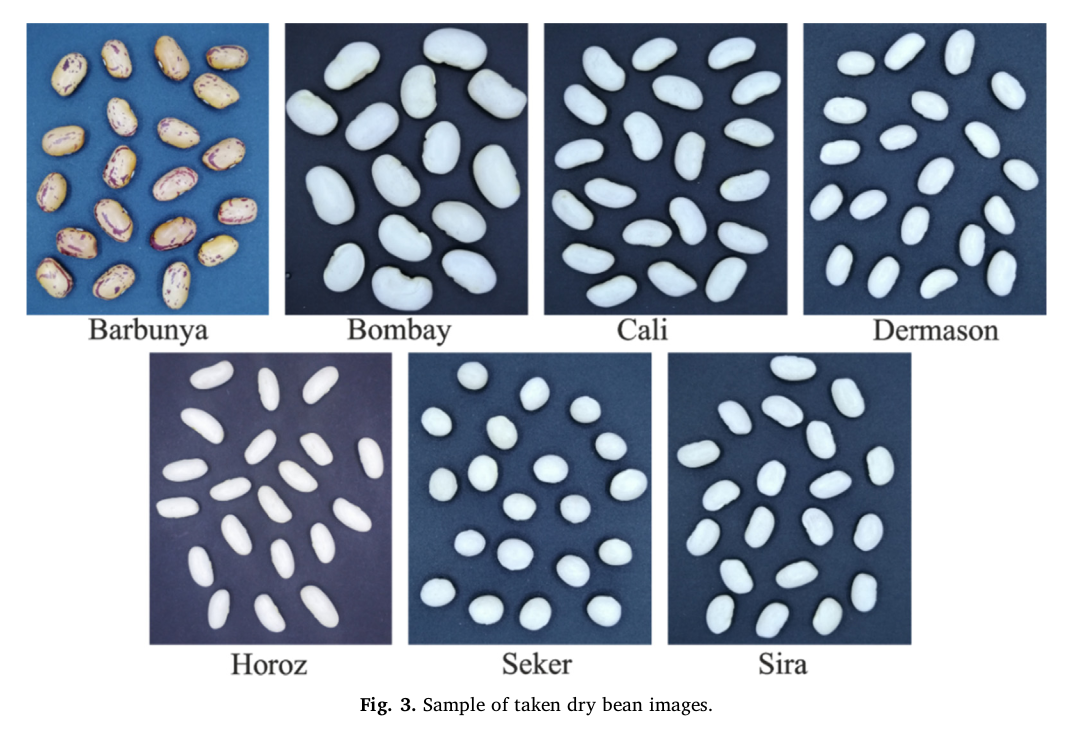

## Definitions

In [12]:
feautres = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4']
target = 'y'
numerical_and_target = feautres + list(target)

## Target Variable

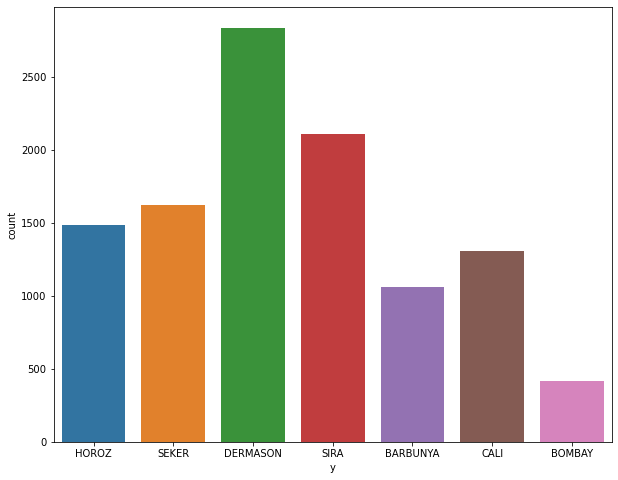

In [13]:
plt.figure(figsize=(10,8))
sns.countplot(x="y", data =train);

In [13]:
train["y"].value_counts(normalize = True)

DERMASON    0.261861
SIRA        0.194665
SEKER       0.149622
HOROZ       0.137345
CALI        0.120362
BARBUNYA    0.097563
BOMBAY      0.038582
Name: y, dtype: float64

Note:
    
    The classes are not balanced in the train dataset.

## Features 

### Data Cleaning
Assertions

In [13]:
assert (train['roundness'] == np.round((4 * np.pi * train['Area']) / (train['Perimeter']**2))).sum() == 0
assert (train['Compactness'] == np.round(train['EquivDiameter'] / train['MajorAxisLength'])).sum() == 0 
assert (train['ShapeFactor1'] == np.round(train['MajorAxisLength'] / train['Area'])).sum() == 0
assert (train['ShapeFactor2'] == np.round(train['MinorAxisLength'] / train['Area'])).sum() == 0
assert (train['ShapeFactor3'] == np.round(train['Area'] / ((train['MajorAxisLength']/2)*(train['MajorAxisLength']/2)* np.pi))).sum() == 0
assert (train['ShapeFactor4'] == np.round(train['Area'] / ((train['MajorAxisLength']/2) * (train['MinorAxisLength']/2) * np.pi))).sum() == 0                                     

All Calculations are correct

### Visual Analysis and Correlations

<AxesSubplot:>

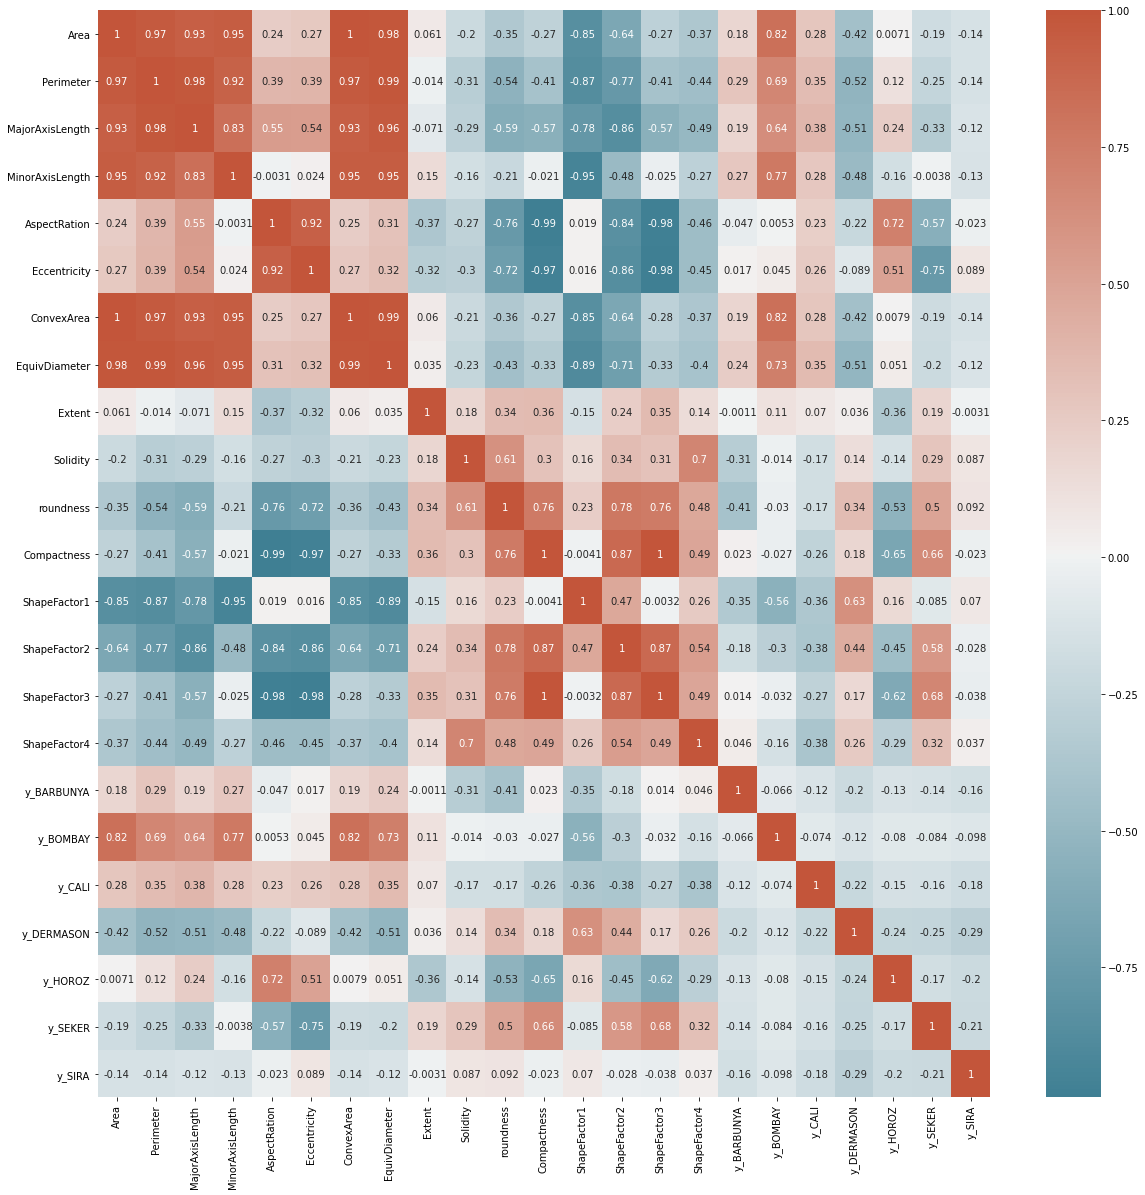

In [99]:
train_with_target_ohe = pd.get_dummies(train, target)
corr = train_with_target_ohe.corr()
plt.figure(figsize=(20,20))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap)

#### Fully Dependant features, corr = 1:
1. Area with Convex Area
2. ShapeFactor3 with compactness

#### corr = 0.99
1. Equiv Diameter and convex area
2. Perimeter and Equiv Diameter
3. Aspect Ration and compactness

#### Getting only correlations greater than 0.5

<AxesSubplot:>

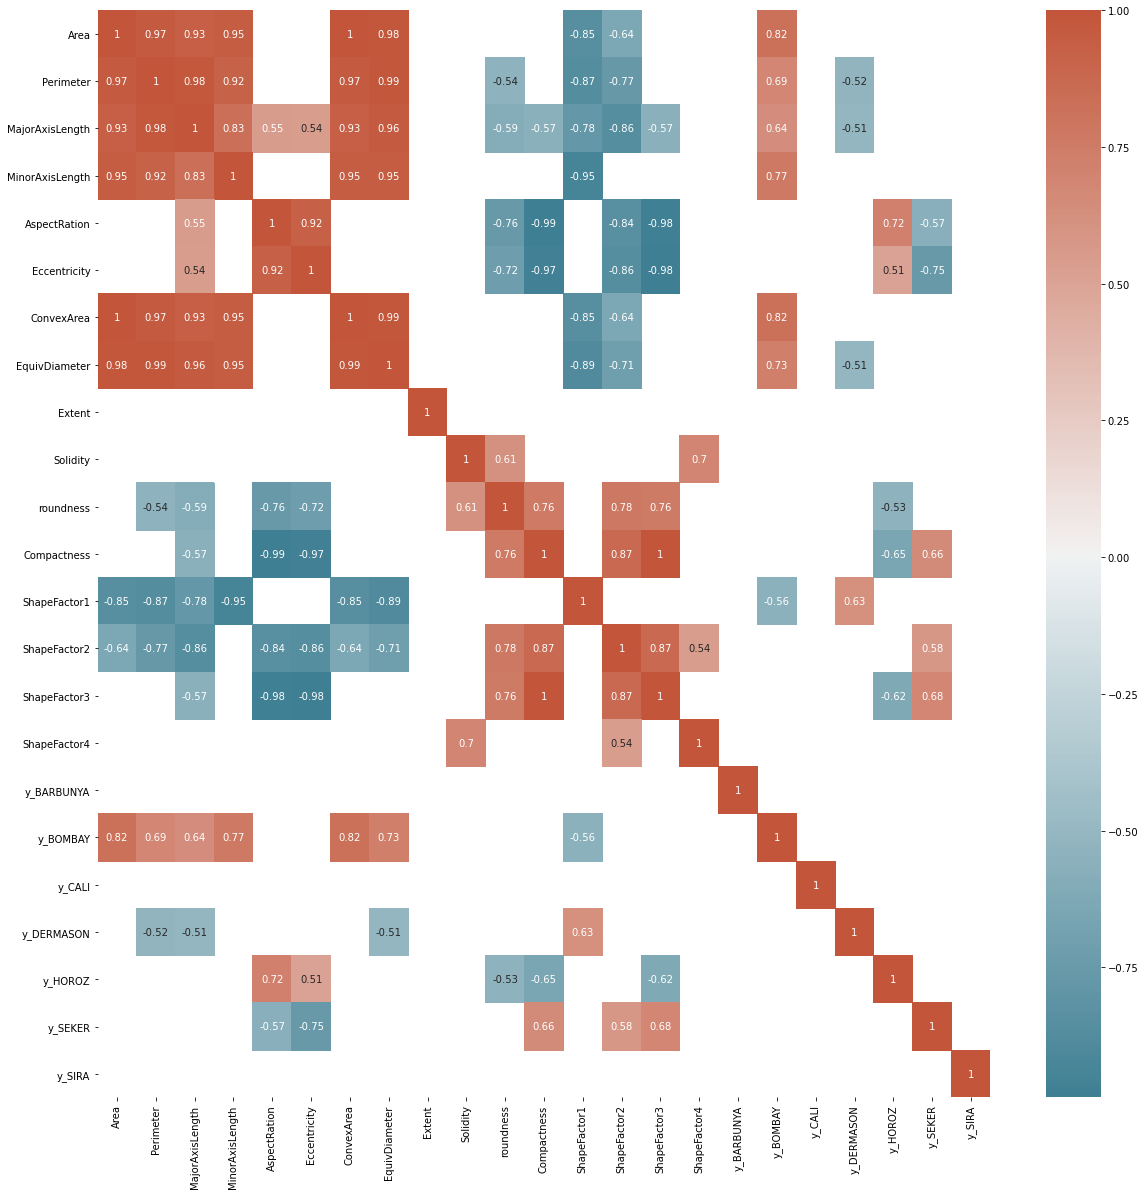

In [100]:
corr[corr>0.5][feautres]
plt.figure(figsize=(20,20))
sns.heatmap(corr[abs(corr)>0.5], annot=True, cmap=cmap)

#### Target variable correlations (greater than 0.5)
1. Barbunya
2. Bombay: Area, Perimeter, MajorAxisLength, MinorAxisLength, ConvexArea, EquivDiameter, ShapeFactor1
3. Cali: 
4. Dermason: Perimeter, MajorAxisLength, EquivDiameter, ShapeFactor1
5. HOROZ: AspectRation, Eccentricity, roundness, compactness, shapefactor3 
6. Seker: AspectRation, Eccentricity, compactness, shapefactor2, shapefactor3
7. Sira: 

Sira, Barbunya, and cali have weak correlations with the features

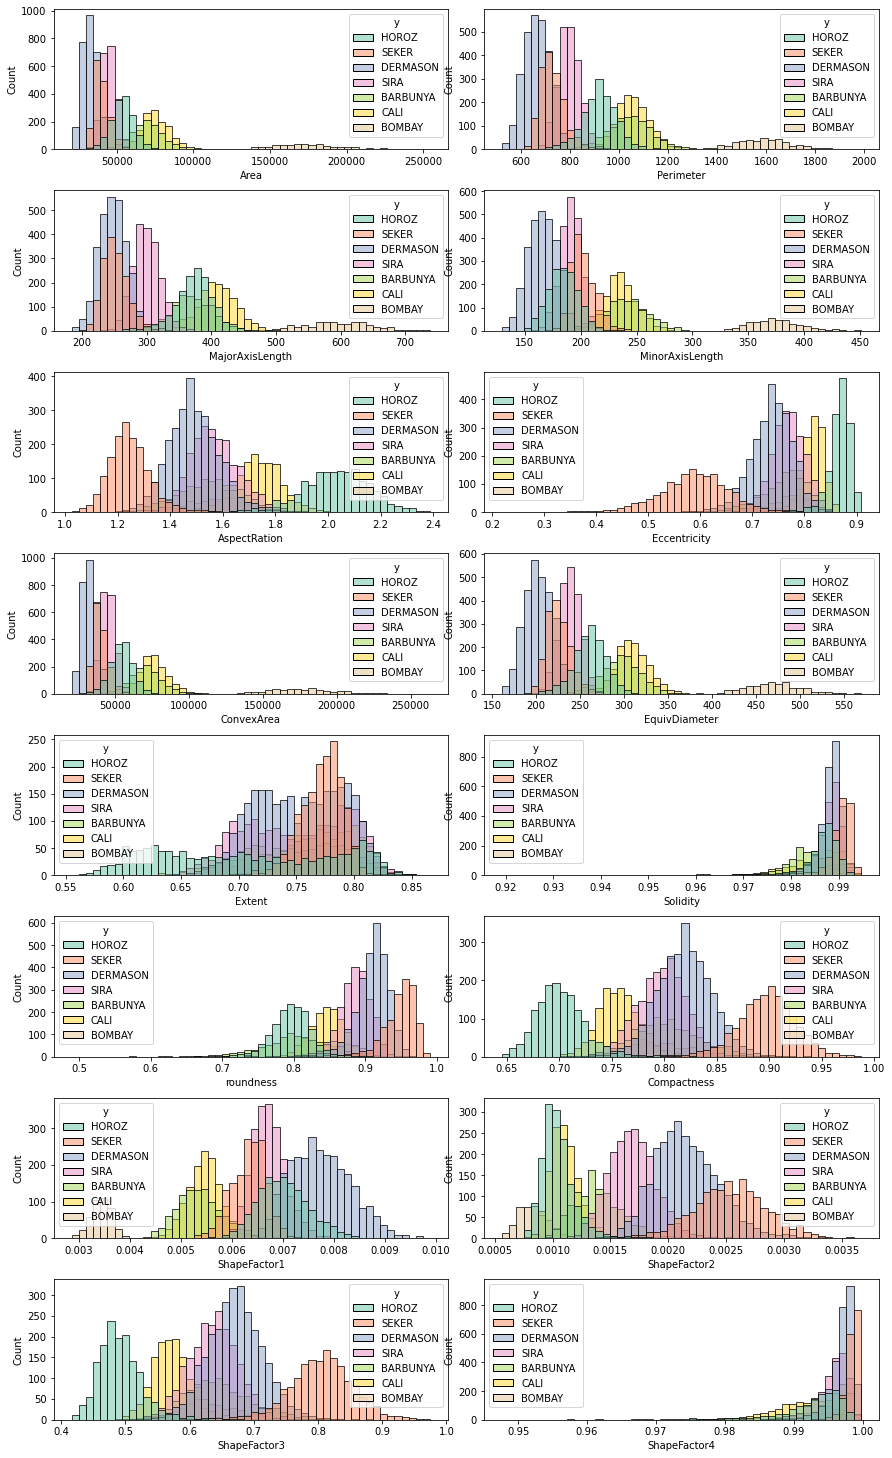

In [76]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows, ncols)

fig.set_size_inches(12, 20)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
feat_iter = 0
sns.set_palette("Set2", 7)
for i in range(0, nrows):
    for j in range(0, ncols):
        sns.histplot(ax=axes[i,j], x = feautres[feat_iter], bins = 50, hue = target, data=train)
        feat_iter+=1 

**As seen previously:**
These features have the same distributions
1. Area and Convex Area
2. ShapeFactor3 and Compactness 
3. Equiv diameter and convex area
4. Aspect Ration and Compactness
5. Equiv diameter and Perimeter

**New Observations**
Some features' histograms are highly overlapped such as:
1. ShapeFactor4
2. Solidity
which may indicate low information gain

**Hypothesis**
Overlapped and dependent features can be removed, We will test this hypthesis through the notebook

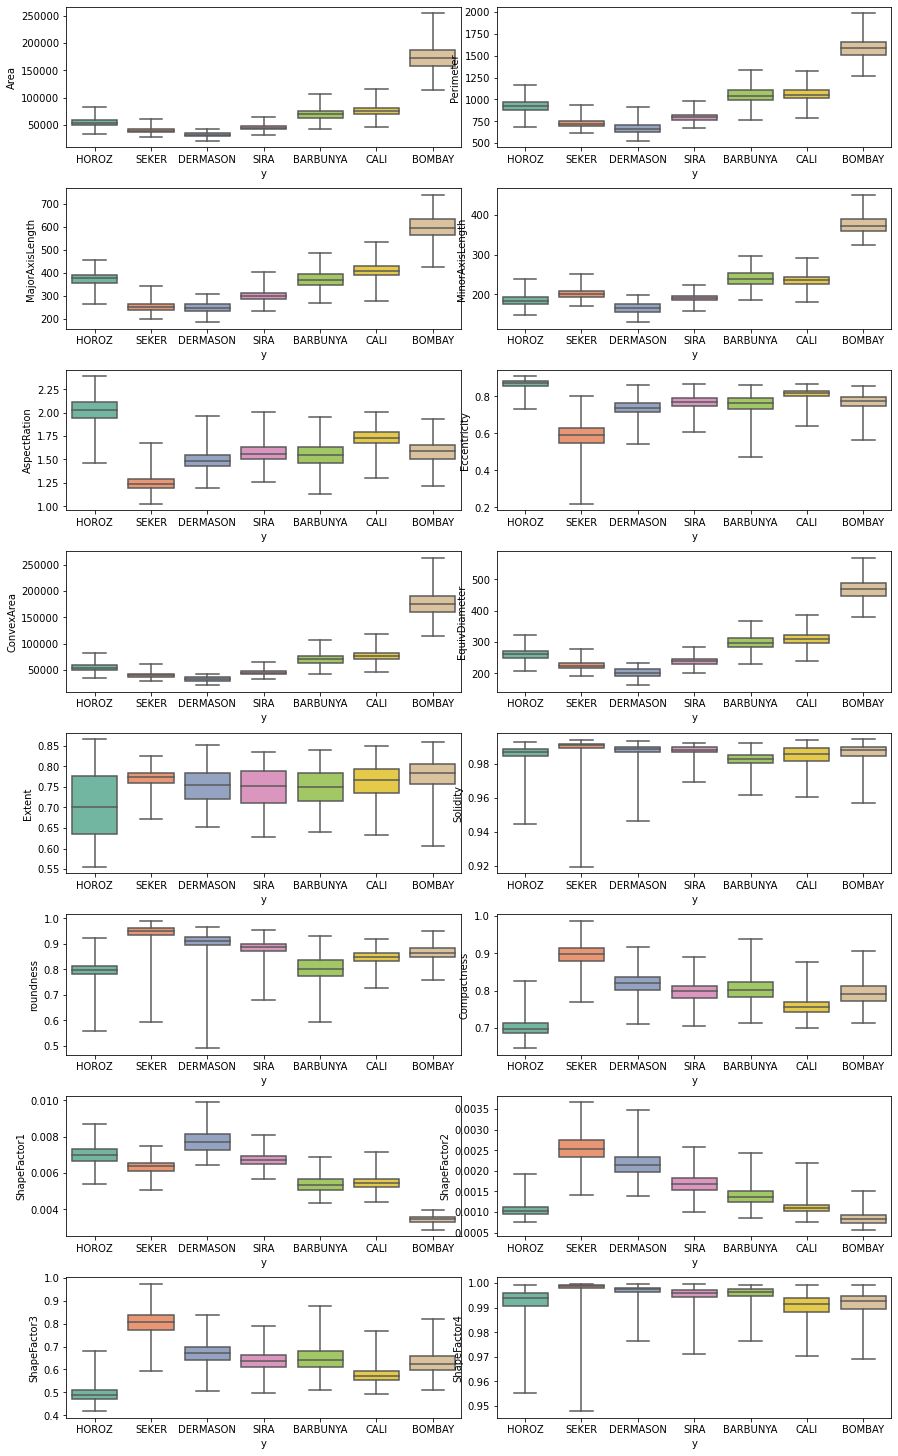

In [19]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows, ncols)

fig.set_size_inches(12, 20)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
feat_iter = 0
for i in range(0, nrows):
    for j in range(0, ncols):
        sns.boxplot(ax=axes[i,j], y = feautres[feat_iter], x = target, data=train, whis = [0,100])
        feat_iter+=1 

### Suggested important features for each bean from boxplot (Hypothesis)
1. HOROZ: ShapeFactor3, ShapeFactor2, Compactness, AspectRation, Eccentricity
2. Seker: ShapeFactor3, ShapeFactor2, Compactness, AspectRation, Eccentricity 
3. Dermason: ShapeFactor1, EquivDiameter, ShapeFactor2
4. Sira: ShapeFactor2, MajorAxisLength
5. Barbunya: ShapeFactor2
6. Cali: ShapeFactor3, ShapeFactor2, Compactness
7. Bombay: ShapeFactor2, ShapeFactor1, ConvexArea, EquivDiameter, MajorAxisLength, MinorAxisLength, Area, Perimeter

It is noticed that some beans have similar distributions such as Dermason and Sira

# Model Preparation

## Useful Functions

In [14]:
def cross_val_custom(model, X, y, classesWeights = [None], folds = 3):
    '''
    Return a true and predicted values for training and validation sets for
    different folds by startified kfolds, after training using the model 
    input parameter. i.e: custom cross validation function as scikit learn
    does not have a way to output training and test values for all folds 
    '''
    y_pred_train_folded = []
    y_pred_test_folded = [] 
    
    y_true_train_folded = []
    y_true_test_folded = []
    
    skf = StratifiedKFold(n_splits=folds,random_state=seed, shuffle=True)
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if classesWeights[0] != None: 
            classesWeightsFold_train = classesWeights[train_index]
            model.fit(X_train, y_train, sample_weight = classesWeightsFold_train)
        else: 
            model.fit(X_train, y_train)
        
        y_pred_train_folded.append(model.predict(X_train))
        y_pred_test_folded.append(model.predict(X_test))
        
        y_true_train_folded.append(y_train)
        y_true_test_folded.append(y_test)
    
    return y_true_train_folded, y_pred_train_folded, y_true_test_folded, y_pred_test_folded      

In [15]:
def get_F1_train_test_scores(y_true_train_folds, y_pred_train_folds, y_true_val_folds, y_pred_val_folds):
    '''
    Return the mean training and validation F1 scores for different folds 
    '''
    f1_scores_folds_train = [f1_score(y_true_train, y_pred_train, average='macro')  
                             for y_true_train, y_pred_train in zip(y_true_train_folds, 
                                                                   y_pred_train_folds)]
    f1_scores_folds_train_mean = np.mean(f1_scores_folds_train)
    f1_scores_folds_val = [f1_score(y_true_val, y_pred_val, average='macro')  
                             for y_true_val, y_pred_val in zip(y_true_val_folds, 
                                                               y_pred_val_folds)]
    f1_scores_folds_val_mean = np.mean(f1_scores_folds_val)
    return f1_scores_folds_train_mean, f1_scores_folds_val_mean

In [16]:
def plot_train_val_cm_heatmap(y_true_train_folds, y_pred_train_folds, y_true_val_folds, y_pred_val_folds, labels_list = [None], folds = 3):
    '''
    Plot the confusion matrix for a randomly chosen fold (training and validation)
    '''
    random_num = random.randint(0,folds-1)
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(14, 6)
    fig.tight_layout() 
    fig.subplots_adjust(wspace=0.05)
    
    cm_xgb_train = confusion_matrix(y_true_train_folds[random_num], y_pred_train_folds[random_num]) 
    cm_xgb_val = confusion_matrix(y_true_val_folds[random_num], y_pred_val_folds[random_num])
    
    sns.heatmap(cm_xgb_train, annot=True, fmt='g', ax = ax[0])
    sns.heatmap(cm_xgb_val, annot=True, fmt='g', ax = ax[1])
    
    ax[0].set_title(('Confusion Matrix for training Data for fold' + str(random_num+1)))
    ax[1].set_title(('Confusion Matrix for validation Data for fold' + str(random_num+1)))
    
    for i in range(2):
        ax[i].set_xlabel('Predicted labels')
        ax[i].set_ylabel('True labels')
        if labels_list[0] != None:
            ax[i].xaxis.set_ticklabels(labels_list)
            ax[i].yaxis.set_ticklabels(labels_list)


In [17]:
def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

## Feature Selection Experiments

### Testing the suggested assumptions from EDA using SequentialFeatureSelector from mlxtend library
The experiment is commented as it takes too much in run time

**Output of Sequential Feature Selection Module**
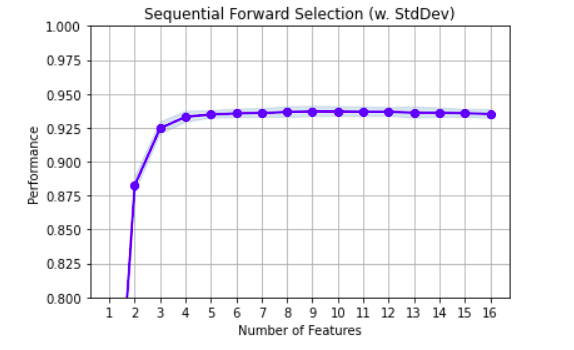

### Sequential Forward Feature Selection choosed features presented in this df

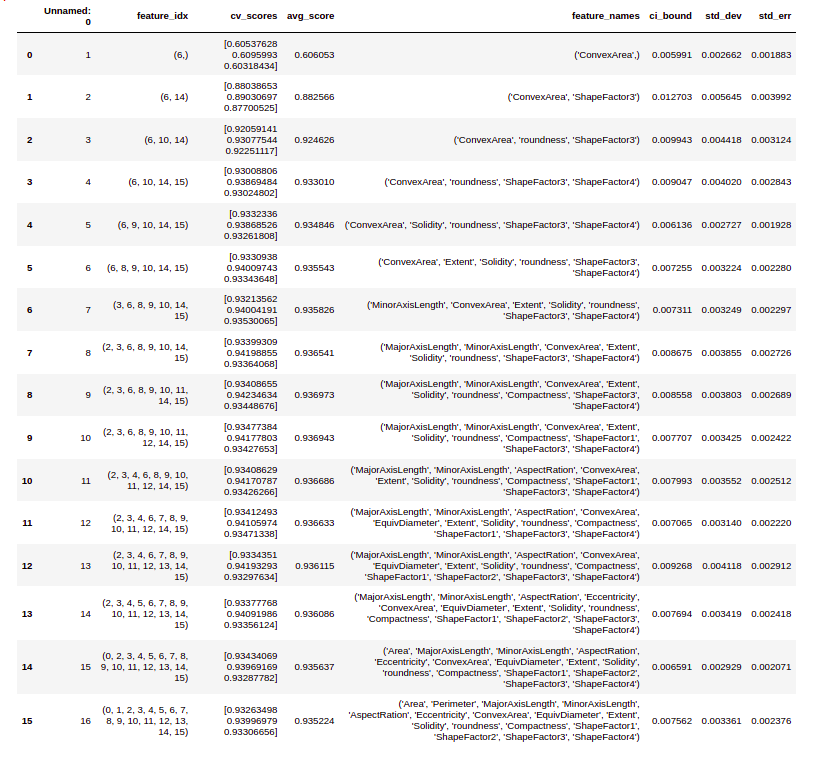

Some overlapped features histograms turned out to be important one such as the solidity, extent, they were chosen in the 4th and 5th iteration indicating they increase the accuracy for the selected model. However, using the above graph, the score nearly remain constant since the fifth iteration indicating the most important features are ('ConvexArea', 'Extent', 'Solidity', 'roundness', 'ShapeFactor3', 'ShapeFactor4')

# Model

In [31]:
train.columns

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'y'],
      dtype='object')

In [372]:
selected_features = ['MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'Extent', 
                     'Solidity', 'roundness', 'Compactness', 'ShapeFactor3', 'ShapeFactor4']
X = train[selected_features] 
X_test = test[selected_features]
y = train[target]
le = LabelEncoder()
y = le.fit_transform(y)

In [373]:
targetMapping = get_integer_mapping(le)

In [374]:
targetMapping

{'BARBUNYA': 0,
 'BOMBAY': 1,
 'CALI': 2,
 'DERMASON': 3,
 'HOROZ': 4,
 'SEKER': 5,
 'SIRA': 6}

## XGB

### Xgboost Model

In [375]:
X = train[selected_features]
X_test = test[selected_features]
n_estimators = 1000
max_depth = 4
colsample_bytree = 0.9
subsample = 0.6
learning_rate = 0.01
eval_metric = "merror"
xgb_model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,colsample_bytree=colsample_bytree,
                              subsample=subsample,learning_rate=learning_rate,objective="multi:softmax",
                              eval_metric =eval_metric, random_state=seed, n_jobs = -1, 
                              use_label_encoder=False)

In [376]:
# using mlflow
EXPORT_MODEL_PATH = 'Experiments'
with open(EXPORT_MODEL_PATH, 'wb') as handle:
    pickle.dump(xgb_model, handle)

In [377]:
EXPERIMENT_NAME = "Model Param v3"

# Initialize client and experiment
client = MlflowClient()
mlflow.set_experiment(EXPERIMENT_NAME)
exp = client.get_experiment_by_name(EXPERIMENT_NAME)

In [378]:
y_true_train_folds, y_pred_train_folds, y_true_val_folds, y_pred_val_folds = cross_val_custom(xgb_model, X, y, folds = 3)

### XGb Analysis

In [379]:
f1_scores_folds_train_mean, f1_scores_folds_val_mean = get_F1_train_test_scores(y_true_train_folds, 
                                            y_pred_train_folds, y_true_val_folds, y_pred_val_folds)
print(f1_scores_folds_train_mean, f1_scores_folds_val_mean)

0.9689432870566281 0.9401353294748374


In [366]:
# Start a new run in the experiment and track 
added_features = None
folds = 3
with mlflow.start_run(experiment_id=exp.experiment_id):
    mlflow.log_param("n_estimators", n_estimators)   # Track model parameter
    mlflow.log_param("max_depth", max_depth) 
    mlflow.log_param("colsample_bytree", colsample_bytree) 
    mlflow.log_param("subsample", subsample) 
    mlflow.log_param("learning_rate", learning_rate) 
    mlflow.log_param("eval_metric", eval_metric) 
    mlflow.log_param("min_child_weight", min_child_weight)
    mlflow.log_param("Selected Features", selected_features) 
    mlflow.log_param("Folds", folds) 
    mlflow.log_param("min split loss", min_split_loss) 
    mlflow.log_param("tree_method", tree_method)
    mlflow.log_param("reg_lambda", reg_lambda)
    mlflow.log_metric("F1 macro training", f1_scores_folds_train_mean)     
    mlflow.log_metric("F1 macro val", f1_scores_folds_val_mean)
    mlflow.log_artifact(EXPORT_MODEL_PATH) # Track exported model

In [367]:
# Initialize client
client = MlflowClient()

# Get experiment and runs 
exp  = client.get_experiment_by_name(EXPERIMENT_NAME)
runs = mlflow.search_runs([exp.experiment_id])
runs # 35, 30 27, 11, 7
# params.reg_lambda	params.colsample_bytree	params.Folds	params.min split loss	params.eval_metric	
# params.Selected Features	params.min_child_weight	params.learning_rate	
# params.n_estimators	params.tree_method	params.max_depth	params.subsample	tags.mlflow.user

,run_id,experiment_id,status,artifact_uri,metrics.F1 macro training,metrics.F1 macro val,params.reg_lambda,params.colsample_bytree,params.Folds,params.min split loss,params.eval_metric,params.Selected Features,params.min_child_weight,params.learning_rate,params.n_estimators,params.tree_method,params.max_depth,params.subsample,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type
0,cc94c041ac8f446d901cefc06e10e4ff,9,FINISHED,file:///home/t/iti/phase%202/challenge/22/Beans/mlruns/9/cc94c041ac8f446d901cefc06e10e4ff/artifacts,0.969774,0.940150,None,0.8,3,0.1,merror,"['MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor3', 'ShapeFactor4', 'EquivDiameter']",0,0.01,1000,auto,4,0.6,t,/home/t/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py,LOCAL
1,fe88e553b3b644c494645f8f45860d61,9,FINISHED,file:///home/t/iti/phase%202/challenge/22/Beans/mlruns/9/fe88e553b3b644c494645f8f45860d61/artifacts,0.969842,0.940348,None,0.8,3,0.2,merror,"['MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor3', 'ShapeFactor4', 'EquivDiameter']",0,0.01,1000,auto,4,0.6,t,/home/t/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py,LOCAL
2,0d201240dc474228a9e78edde8e9e143,9,FINISHED,file:///home/t/iti/phase%202/challenge/22/Beans/mlruns/9/0d201240dc474228a9e78edde8e9e143/artifacts,0.975950,0.940452,None,0.8,3,0.2,merror,"['MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor3', 'ShapeFactor4', 'EquivDiameter']",0,0.01,1200,auto,4,0.6,t,/home/t/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py,LOCAL
3,ca0b61ec75354ed8a53efa03b13bdb9d,9,FINISHED,file:///home/t/iti/phase%202/challenge/22/Beans/mlruns/9/ca0b61ec75354ed8a53efa03b13bdb9d/artifacts,0.975950,0.940452,None,0.8,3,0.2,merror,"['MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor3', 'ShapeFactor4', 'EquivDiameter']",0,0.01,1200,exact,4,0.6,t,/home/t/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py,LOCAL
4,8e3357d2a2524f96b2e8629c60043e0d,9,FINISHED,file:///home/t/iti/phase%202/challenge/22/Beans/mlruns/9/8e3357d2a2524f96b2e8629c60043e0d/artifacts,0.976216,0.940217,None,0.8,3,None,merror,"['MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor3', 'ShapeFactor4', 'EquivDiameter']",0,0.01,1200,auto,4,0.6,t,/home/t/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py,LOCAL
5,b4d074e49b584e43a18dc9d6bfb0f4e8,9,FINISHED,file:///home/t/iti/phase%202/challenge/22/Beans/mlruns/9/b4d074e49b584e43a18dc9d6bfb0f4e8/artifacts,0.976216,0.940217,None,0.8,3,None,merror,"['MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor3', 'ShapeFactor4', 'EquivDiameter']",0,0.01,1200,exact,4,0.6,t,/home/t/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py,LOCAL
6,23ccdd9f6708476187730bb58480ddeb,9,FINISHED,file:///home/t/iti/phase%202/challenge/22/Beans/mlruns/9/23ccdd9f6708476187730bb58480ddeb/artifacts,0.974669,0.939980,2,0.8,3,0.2,merror,"['MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor3', 'ShapeFactor4', 'EquivDiameter']",0,0.01,1500,exact,7,0.15,t,/home/t/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py,LOCAL
7,ffdd43043db041aaaa87c8a40b4a701d,9,FINISHED,file:///home/t/iti/phase%202/challenge/22/Beans/mlruns/9/ffdd43043db041aaaa87c8a40b4a701d/artifacts,0.969987,0.939548,2,0.8,3,0.2,merror,"['MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor3', 'ShapeFactor4', 'EquivDiameter']",0,0.01,1200,exact,7,0.15,t,/home/t/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py,LOCAL
8,4d0e6dfac5554ed2af410c8a1807fd9f,9,FINISHED,file:///home/t/iti/phase%202/challenge/22/Beans

In [368]:
"""
def 0.028808
35 0.028474 0.940164
35 0.029599 0.940341
27 0.032605 0.940431
11 0.038403 0.940799
7 0.029626  0.940290
"""

'\ndef 0.028808\n35 0.028474 0.940164\n35 0.029599 0.940341\n27 0.032605 0.940431\n11 0.038403 0.940799\n7 0.029626  0.940290\n'

In [369]:
labels_list = list(np.unique(le.inverse_transform(y)))
labels_list

['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']

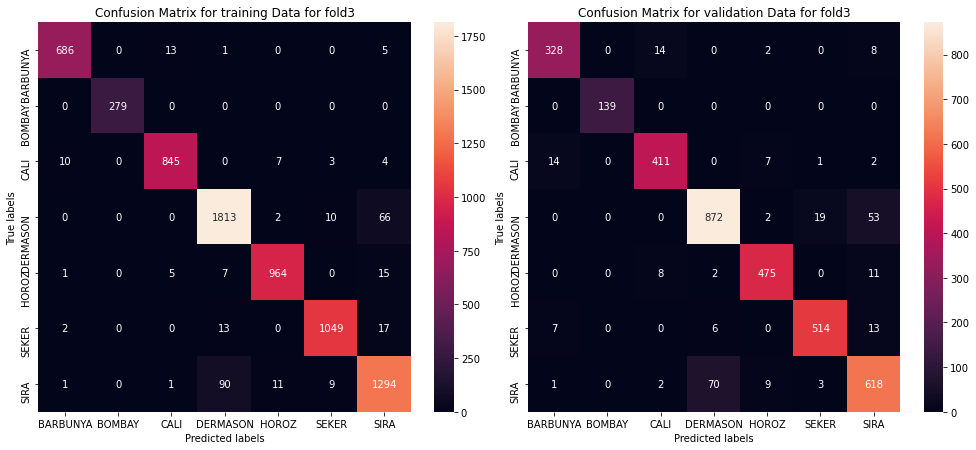

In [370]:
plot_train_val_cm_heatmap(y_true_train_folds, y_pred_train_folds, y_true_val_folds, y_pred_val_folds, labels_list = labels_list)
        

##### The model can't differentiate well between Dermason and Sira 

### Adding more weight to Dermason and Sira

In [524]:
targetMapping

{'BARBUNYA': 0,
 'BOMBAY': 1,
 'CALI': 2,
 'DERMASON': 3,
 'HOROZ': 4,
 'SEKER': 5,
 'SIRA': 6}

In [21]:
class_weight_dict ={
    'BARBUNYA': 1,
    'BOMBAY': 1,
    'CALI': 1,
    'DERMASON': 1.3,
    'HOROZ': 1,
    'SEKER': 1,
    'SIRA': 2.1 
}
classes_weights = class_weight.compute_sample_weight(
    class_weight=class_weight_dict,
    y=train[target]
)

In [25]:
EXPERIMENT_NAME = "Class Weights"

# Initialize client and experiment
mlflow.set_experiment(EXPERIMENT_NAME)
exp = client.get_experiment_by_name(EXPERIMENT_NAME)

In [26]:
y_true_train_folds, y_pred_train_folds, y_true_val_folds, y_pred_val_folds = cross_val_custom(xgb_model, X, y, classes_weights)

In [27]:
f1_scores_folds_train_mean, f1_scores_folds_val_mean = get_F1_train_test_scores(y_true_train_folds, 
                                            y_pred_train_folds, y_true_val_folds, y_pred_val_folds)
print(f1_scores_folds_train_mean, f1_scores_folds_val_mean)

0.9692072465445217 0.9413567855634407


In [29]:
# Start a new run in the experiment and track 
log_used_features = False
with mlflow.start_run(experiment_id=exp.experiment_id):
    mlflow.log_param("class weights", class_weight_dict)   # Track model parameter
    mlflow.log_param("log", log_used_features) 
    mlflow.log_metric("F1 macro training", f1_scores_folds_train_mean)     
    mlflow.log_metric("F1 macro val", f1_scores_folds_val_mean)
    mlflow.log_artifact(EXPORT_MODEL_PATH) # Track exported model

In [30]:
# Initialize client
client = MlflowClient()

# Get experiment and runs 
exp  = client.get_experiment_by_name(EXPERIMENT_NAME)
runs = mlflow.search_runs([exp.experiment_id])
runs 

,run_id,experiment_id,status,artifact_uri,metrics.F1 macro training,metrics.F1 macro val,params.class weights,params.log,params.added_features,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name
0,33cf9ab2efed471e8b1d14904fe557eb,2,FINISHED,file:///home/t/iti/phase%202/challenge/2/mlrun...,0.969207,0.941357,"{'BARBUNYA': 1, 'BOMBAY': 1, 'CALI': 1, 'DERMA...",False,None,t,LOCAL,/home/t/anaconda3/lib/python3.8/site-packages/...
1,cae96d8941e44e21beca34f3259cb21c,2,FAILED,file:///home/t/iti/phase%202/challenge/2/mlrun...,NaN,NaN,"{'BARBUNYA': 1, 'BOMBAY': 1, 'CALI': 1, 'DERMA...",False,None,t,LOCAL,/home/t/anaconda3/lib/python3.8/site-packages/...
2,85b53631a6a0491e9899efe6412506ee,2,FINISHED,file:///home/t/iti/phase%202/challenge/2/mlrun...,0.969207,0.941357,"{'BARBUNYA': 1, 'BOMBAY': 1, 'CALI': 1, 'DERMA...",False,None,t,LOCAL,/home/t/anaconda3/lib/python3.8/site-packages/...
3,ce775cb6b69e420e99d60e846b24ce46,2,FINISHED,file:///home/t/iti/phase%202/challenge/2/mlrun...,0.969350,0.941008,"{'BARBUNYA': 1, 'BOMBAY': 1, 'CALI': 1, 'DERMA...",False,sf5,t,LOCAL,/home/t/anaconda3/lib/python3.8/site-packages/...
4,651b915436a044609ea5bbc7a0a8219c,2,FINISHED,file:///home/t/iti/phase%202/challenge/2/mlrun...,0.969653,0.941117,"{'BARBUNYA': 1, 'BOMBAY': 1, 'CALI': 1, 'DERMA...",False,sf5,t,LOCAL,/home/t/anaconda3/lib/python3.8/site-packages/...
5,ca910cf0b2c74b94b1012c4ad8cf0bf5,2,FINISHED,file:///home/t/iti/phase%202/challenge/2/mlrun...,0.969786,0.941034,"{'BARBUNYA': 1, 'BOMBAY': 1, 'CALI': 1, 'DERMA...",False,sf5,t,LOCAL,/home/t/anaconda3/lib/python3.8/site-packages/...
6,d933ce9caae34c509754b451a926bcaa,2,FINISHED,file:///home/t/iti/phase%202/challenge/2/mlrun...,0.969207,0.941357,"{'BARBUNYA': 1, 'BOMBAY': 1, 'CALI': 1, 'DERMA...",False,None,t,LOCAL,/home/t/anaconda3/lib/python3.8/site-packages/...
7,af56bb0531ef4ceda2ecc06c41fdc6b8,2,FINISHED,file:///home/t/iti/phase%202/challenge/2/mlrun...,0.969401,0.941178,"{'BARBUNYA': 1, 'BOMBAY': 1, 'CALI': 1, 'DERMA...",True,None,t,LOCAL,/home/t/anaconda3/lib/python3.8/site-packages/...
8,c7a3744887874e8cb1cd52b08fefcc33,2,FINISHED,file:///home/t/iti/phase%202/challenge/2/mlrun...,0.969207,0.941357,"{'BARBUNYA': 1, 'BOMBAY': 1, 'CALI': 1, 'DERMA...",None,None,t,LOCAL,/home/t/anaconda3/lib/python3.8/site-packages/...
9,d0ddc0a55e154c76b98a3f45e43bf43a,2,FINISHED,file:///home/t/iti/phase%202/challenge/2/mlrun...,0.969997,0.941153,"{'BARBUNYA': 1, 'BOMBAY': 1, 'CALI': 1, 'DERMA...",None,None,t,LOCAL,/home/t/anaconda3/lib/python3.8/site-packages/...


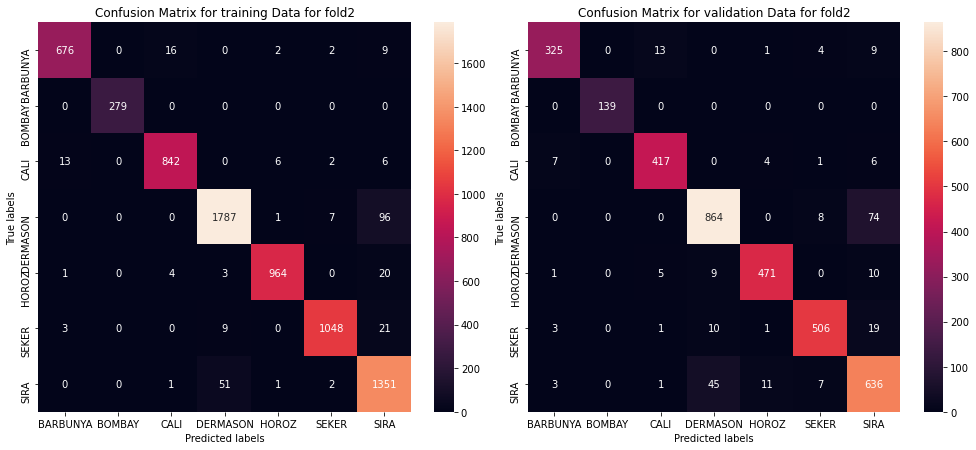

In [34]:
plot_train_val_cm_heatmap(y_true_train_folds, y_pred_train_folds, y_true_val_folds, y_pred_val_folds, labels_list = labels_list)
        


##### F1 score increased minimally in the validation set, not in the test set. So the weights are removed

### XGB Test and Submission

In [371]:
xgb_model.fit(X,y)
y_train_predicted = xgb_model.predict(X)
y_test_predicted = xgb_model.predict(X_test)
print(f1_score(y, y_train_predicted, average='macro'))
y_train_predicted = le.inverse_transform(y_train_predicted)
y_test_predicted = le.inverse_transform(y_test_predicted) 
y_test_predicted
#0.9636142708498358

0.9628483645521477


array(['HOROZ', 'DERMASON', 'BARBUNYA', ..., 'HOROZ', 'DERMASON', 'SIRA'],
      dtype=object)

In [37]:
test["y"] = y_test_predicted
test[['ID','y']].to_csv('./submission.csv', index=False)